## Supply Chain Network Design: Martin-Beck Co.

In [1]:
import numpy as np
from ortools.linear_solver import pywraplp as glp    # import Glop package
import lptools as lpt

In [2]:
# plant name: fixed cost (thousand $), unit shipping cost ($) to each RDC, supply capacity (thousands of tons), 
Plants = {'Det': (175, [ 5, 2, 3], 10),    # Detroit
          'Tol': (300, [ 4, 3, 4], 20),    # Toledo
          'Den': (375, [ 9, 7, 5], 30),    # Denver
          'KC':  (500, [10, 4, 2], 40),    # Kansas City
          'StL': (  0, [ 8, 4, 3], 30)}    # Saint Louis

# RDC name: demand quantity required (thousands of tons)
RDCs = {'Bos':30, 'Atl':20, 'Hou':20}    # Boston, Atlanta, Houston


In [3]:
# create MILP model object
mymodel = glp.Solver.CreateSolver('CBC')    # CBC solver algorithm needed to solve a model containing INTEGER variables
inf = mymodel.infinity()

In [4]:
# create dictionary of binary decision variables for each plant
Y = {p: mymodel.IntVar(0, 1, p) for p in Plants}

# can use an outer for loop rather than nested dictionary comprehension
# create dictionary of shipment variables from plants to RDCs
X = {p: {rdc: mymodel.NumVar(0, inf, f'{p}.{rdc}') for rdc in RDCs} for p in Plants}


In [5]:
# create objective to minimize total fixed plant costs and shipping costs
mymodel.Minimize(sum(Plants[p][0]*Y[p] for p in Plants)                                 # total fixed plant costs
                 + sum(c*x for p in Plants for (c, x) in zip(Plants[p][1], X[p].values())))    # total shipping costs


In [6]:
# create plant capacity constraints
for p in Plants:
    mymodel.Add(sum(X[p][rdc] for rdc in RDCs) <= Plants[p][2]*Y[p], f'Plant.{p}')    # create the plant p inequality (<=) constraint 
                                                                                      # with upper bound Plants[p][2]*Y[p]

In [8]:
# create RDC demand constraints
for rdc in RDCs:                                                          # for each rdc
    mymodel.Add(sum(X[p][rdc] for p in Plants) == RDCs[rdc], f'RDC.{rdc}')    # create the rdc's equality constraint  
                                                                              # with demand requirement == RDCs[rdc]
    

In [9]:
lpt.print_model(mymodel)

Variables:
Det, Tol, Den, KC, StL, Det.Bos, Det.Atl, Det.Hou, Tol.Bos, Tol.Atl, Tol.Hou, Den.Bos, Den.Atl, Den.Hou, KC.Bos, KC.Atl, KC.Hou, StL.Bos, StL.Atl, StL.Hou 

minimize: 175.0*Det + 300.0*Tol + 375.0*Den + 500.0*KC + 5.0*Det.Bos + 2.0*Det.Atl + 3.0*Det.Hou + 4.0*Tol.Bos + 3.0*Tol.Atl + 4.0*Tol.Hou + 9.0*Den.Bos + 7.0*Den.Atl + 5.0*Den.Hou + 10.0*KC.Bos + 4.0*KC.Atl + 2.0*KC.Hou + 8.0*StL.Bos + 4.0*StL.Atl + 3.0*StL.Hou 

Subject To:
Plant.Det: - 10.0*Det + 1.0*Det.Bos + 1.0*Det.Atl + 1.0*Det.Hou <= 0.0
Plant.Tol: - 20.0*Tol + 1.0*Tol.Bos + 1.0*Tol.Atl + 1.0*Tol.Hou <= 0.0
Plant.Den: - 30.0*Den + 1.0*Den.Bos + 1.0*Den.Atl + 1.0*Den.Hou <= 0.0
Plant.KC: - 40.0*KC + 1.0*KC.Bos + 1.0*KC.Atl + 1.0*KC.Hou <= 0.0
Plant.StL: - 30.0*StL + 1.0*StL.Bos + 1.0*StL.Atl + 1.0*StL.Hou <= 0.0
RDC.Bos: 1.0*Det.Bos + 1.0*Tol.Bos + 1.0*Den.Bos + 1.0*KC.Bos + 1.0*StL.Bos = 30.0
RDC.Atl: 1.0*Det.Atl + 1.0*Tol.Atl + 1.0*Den.Atl + 1.0*KC.Atl + 1.0*StL.Atl = 20.0
RDC.Hou: 1.0*Det.Hou + 1.0*Tol.Hou + 1.

In [10]:
#solve model and display results
status = mymodel.Solve()
print(f'Solution Status = {status}')
print(f'Optimal Value = ${mymodel.Objective().Value():,.2f} thousand')
for v in mymodel.variables():
    if v.solution_value() != 0: print(f'{v.name():s} = {v.solution_value():.1f}')

Solution Status = 0
Optimal Value = $860.00 thousand
KC = 1.0
StL = 1.0
KC.Atl = 20.0
KC.Hou = 20.0
StL.Bos = 30.0


In [11]:
# display variable information
# print('Variable    LB   Value    UB')
# for v in mymodel.variables():
#     print(f'{v.name():8s}  {v.lb():5.1f}  {v.solution_value():5.1f}  {v.ub():5.1f}')

In [12]:
#display constraint information
print('Constraint   LB    Value   UB')
for (c,lhs) in zip(mymodel.constraints(),mymodel.ComputeConstraintActivities()):
    print(f'{c.name():10s}  {c.lb():5.1f}  {lhs:5.1f}  {c.ub():5.1f}')

Constraint   LB    Value   UB
Plant.Det    -inf    0.0    0.0
Plant.Tol    -inf    0.0    0.0
Plant.Den    -inf    0.0    0.0
Plant.KC     -inf    0.0    0.0
Plant.StL    -inf    0.0    0.0
RDC.Bos      30.0   30.0   30.0
RDC.Atl      20.0   20.0   20.0
RDC.Hou      20.0   20.0   20.0


### Optimization Parameter Analysis

In [13]:
import matplotlib.pyplot as plt

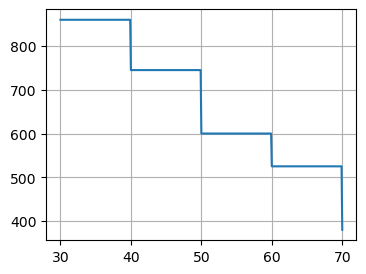

In [14]:
# optimization parameter analysis: St.Louis capacity (30 - 70)

param_lst = [b/10 for b in range(300, 701)]
optval_lst = []
for b in param_lst:
    mymodel.constraints()[4].SetCoefficient(Y['StL'], -b)    # St. Louis is constraint index 4
    mymodel.Solve()
    optval_lst.append(mymodel.Objective().Value())
    
mymodel.constraints()[4].SetCoefficient(Y['StL'], -30)    # reset St. Louis capacity to its original value

plt.figure(figsize=(4,3))
plt.grid()
plt.plot(param_lst,optval_lst)

Step Changes  
30 - KC, StL  
40 - Det, Tol, StL  
50 - Tol, StL  
60 - Det, StL  
70 - StL  

### Logical Constraint

In [15]:
# at least one plant in Detroit or Toledo
new_constr = mymodel.Add(Y['Det']+Y['Tol'] >= 1, 'Det_Tol')

#solve model and display results
status = mymodel.Solve()
print(f'Solution Status = {status}')
print(f'Optimal Value = ${mymodel.Objective().Value():,.2f} thousand')
for v in mymodel.variables():
    if v.solution_value() != 0: print(f'{v.name():s} = {v.solution_value():.1f}')

new_constr.SetBounds(-inf, inf)    # relax/drop the new constraint

Solution Status = 0
Optimal Value = $940.00 thousand
Det = 1.0
Den = 1.0
StL = 1.0
Det.Bos = 10.0
Den.Bos = 20.0
Den.Hou = 10.0
StL.Atl = 20.0
StL.Hou = 10.0


### Generating Alternate Solutions

In [16]:
# reset to original optimal solution
#solve model and display results
status = mymodel.Solve()
print('Solution Status =',status)
print('Optimal Value = %.2f thousand' % mymodel.Objective().Value())
for v in mymodel.variables():
    if v.solution_value() != 0:
        print('%7s = %5.2f' % (v.name(),v.solution_value()))

Solution Status = 0
Optimal Value = 860.00 thousand
     KC =  1.00
    StL =  1.00
 KC.Atl = 20.00
 KC.Hou = 20.00
StL.Bos = 30.00


In [18]:
# create new cut constraint

cut_coeffs = []              # list of coefficents for the new cut constraint
M = 0                        # counts the number of '1's in the current optimal solution

for p in Plants:    # for each binary plant decision variable
    if Y[p].solution_value() == 1:  # if the binary variable's value is '1'
        cut_coeffs.append(1)        # the cut constraint coefficient for this variable is '1'
        M += 1                      # and increment M by 1
        
    else: cut_coeffs.append(-1)  # otherwise the variable's value is '0'
                                 # and the cut constraint coefficient for this variable is '-1'
        
print(f'{M =}  {cut_coeffs=}')

# add the new cut constraint
cut_constr = mymodel.Add(sum(a*y for (a, y) in zip(cut_coeffs, Y.values())) <= M - 1, f'Cut.{M}.{cut_coeffs}')

# solve model and display results
status = mymodel.Solve()
print(f'Solution Status = {status}')
print(f'Optimal Value = ${mymodel.Objective().Value():,.2f}')
for v in mymodel.variables():
    if v.solution_value() != 0: print(f'{v.name():s} = {v.solution_value():.1f}')
            
# relax cut constraint
# cut_constr.SetBounds(-inf, inf)

M =2  cut_coeffs=[-1, -1, -1, 1, 1]
Solution Status = 0
Optimal Value = $940.00
Det = 1.0
Den = 1.0
StL = 1.0
Det.Bos = 10.0
Den.Bos = 20.0
Den.Hou = 10.0
StL.Atl = 20.0
StL.Hou = 10.0
